# Using our LID Estimators

---
author: "Hamidreza Kamkari"
code-tools: true
code-fold: true
jupyter: python3
---

This Notebook guides you through the process of using our LID estimators. We deal with two different types of LID estiamtors: (1) ones that require training or fitting a deep generative model (or can alternatively use a pre-trained one), and (2) traditional LID estiamtors that are "model-free" and do not require training. Let us go over them one by one, but before we do, make sure to run the following cell to initialize the notebook first and take a look at the [manifold dataset](./manifold_datasets.html) notebook that contains our manifold datasets where we have access to the underlying manifold with the ground truth LID.

In [2]:
#| output: false
#| warning: false

from notebook_setup import device

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

%load_ext autoreload

## Model-Free Estimators

Common model-free LID estimators are lPCA, ESS, and MLE. To run model-free estimators, setup your mlflow and run scripts in the following format:
```{.bash}
python scripts/model_free_lid.py dataset=<dataset> lid_method=<lid-method> +experiment=<lid_greyscale | lid_rgb | lid_tabular> subsample_size=<subsample-size>
```
Explanation of the arguments:

1. `dataset`: The dataset to run the LID estimator on. We have an extensive suite of datasets including `lollipop`, `swiss_roll`, `cifar10`, `mnist`, to name a few. To see the full list, check out the `conf/datasets` directory of the codebase.
2. `lid_method`: The LID estimator to run. The available LID estimators include `lpca`, `ess`, and `mle` to name a few.
3. `experiment_dir`: The directory to save the experiment outputs. The available directories include `lid_greyscale`, `lid_rgb`, and `lid_tabular` for grayscale (28x28), RGB (3x32x32), and tabular datasets, respectively.
4. `subsample_size`: This performs a subsampling of the dataset to the specified size. This is useful for high-dimensional datasets like CIFAR-10 and MNIST where computing these model-free estimators is intractable for the entire dataset.

Example runs:
```{.bash}
# Lollipop runs:
python scripts/model_free_lid.py dataset=lollipop lid_method=ess +experiment=lid_tabular subsample_size=10000
python scripts/model_free_lid.py dataset=lollipop lid_method=lpca +experiment=lid_tabular subsample_size=10000
# Image Greyscale runs
python scripts/model_free_lid.py dataset=mnist lid_method=ess +experiment=lid_greyscale subsample_size=4096
python scripts/model_free_lid.py dataset=fmnist lid_method=lpca +experiment=lid_greyscale subsample_size=4096
# Image RGB runs
python scripts/model_free_lid.py dataset=cifar10 lid_method=ess +experiment=lid_rgb subsample_size=4096
```

### How to interpret the output

You should first setup your Mlflow server. Then, you can visualize the outputs for each of these runs. The outputs include the following:

1. **Estimation heatmap**: For a holistic view, these scripts will log the UMAP embedding of all the dataset and for each point, they will log the estimated value of LID in the `lid_image/heatmap_pred.png` file in the artifacts and the true LIDs (if available) will be logged `lid_image/heatmap_gt.png` file in the artifacts. For example, the images will not have a ground truth files. You can also set the run to not log the heatmap by setting `visualize_manifold=null`.
2. **Detailed evaluation**: A detailed evaluation of the LID estimator is logged in the `results.yaml` file in the artifacts. This includes the mean absolute error, mean squared error, concordance index, and many other summary statistics to show how well the LID estimator performed. In cases where the ground truth is not available, you can check the average estimated LID values to see how well the LID estimator performed. You can also see how well the LID estimator performs on each individual submanifold for datasets with multiple known submanifolds (such as lollipop).
3. **Raw prediction**: To perform any additional analysis, the raw predictions are also logged in the `prediction.csv` file in the artifacts that you can download and analyze.

### How to tweak the setting

As with the rest of the codebase, we use Hydra and one can tweak the configurations above in the command-line. For example, you can set the time hyperparameter of `ess` to another value that works better:
```{.bash}
# increase the number of neighbours for the estimator
python scripts/model_free_lid.py dataset=fmnist lid_method=lpca +experiment=lid_greyscale subsample_size=10000 lid_method.preprocess_args.n_neighbours=1000
```
For a more detailed look, you can take a look at the appropriate Hydra configurations in the `conf/lid_method/` directory.


## Model-based Estimators (using `scripts`)

Similar to the scripts we use for model-free estimators, we have scripts for model-based estimators. Since the model-based estimators require training a deep generative model, these estimators have been developed as a lightning callback to monitor the LID during training. In case, you want to use your pre-trained model, you can simply set the checkpoint argument. For example, we have already included checkpoints for FMNIST/MNIST/CIFAR-10/SVHN, and if you run `scripts/download_resources.py` they should already be downloaded for you. A simple example would be to run the following:

```{.bash}
python scripts/train.py dataset=mnist +experiment=train_flow_greyscale +checkpoint=flow_mnist +callbacks@all_callbacks.monitor_lid=flow_jacobian_threshold_lid
```

This script uses a pre-trained normalizing flow on MNIST images and employs the Jacobian of the flow push-forward for each individual datapoint to estimate LID. Specifically, it examines the singular values of this Jacobian and uses the threshold $\tau$ to determine the intrinsic dimension, defined as the number of singular values exceeding the threshold. For more information on this estimator, refer to our paper [@kamkari2024oodlid].

After running the script, you can check the artifact directory of MLFlow. You will find a folder named `MultiMetrics`, which contains a `metrics=xxx.csv` file. This file includes a column with the estimated LID values for each datapoint. Additionally, you can explore the `samples` sub-directory to see the samples for which LID was evaluated. A list of all the callbacks are available in the `conf/callbacks` directory where you can invoke other LID estimators as well.

Before we dive into the details of each estimator, let's first cover some of the basic things that *all* of these callbacks log:

1. **Data summary**: The callback logs the data summary in the `{logging_folder_name}/manifold_info.csv` file in the artifacts directory. This will include all the subsampled datapoints information. If for example, these are from synthetic data where the manifold structure is known, then the columns `lid` and `submanifold` will contain the true LID values and the submanifold labels respectively. If not, then these columns will be filled by `-1` and `0` respectively; this for example happens with image datasets.

2. **Seeing samples**:  All the samples will be logged in `{logging_folder_name}/samples/` directory. It will be either a `.csv` file if the data is tabular and a set of `.png` and `.npy` files if the data is an image. In addition to that, each sample has a transformed and an untransformed version. This is because the DGM also has a set of post-hoc transformations that are applied after the DGM generates the samples.

3. **Evaluating**: In all of the monitoring callbacks where a csv file is stored that contains information about all the datapoints, the index of the data (the row it resides in) is consistent with the row in the `{logging_folder_name}/manifold_info.csv`. Thus, you can join tables and evaluate the performance of LID estimators on a per-sample basis if you want to.

Now let's dive into each individual estimator:



### Flow Estimators: Using the Jacobian of the Flow Push-Forward

This estimator is tailored towards normalizing flows where the mapping from the latent space to the data space is easy to acces and differentiate. All of them work by computing the Jacobian of the flow push-forward for each individual datapoint and estimating the LID based on this Jacobian. Both of them use some sort of scale parameter $\tau$ to determine the intrinsic dimensionality of the manifold. After running the following scripts, you should be able to reproduce the following curves, indicating the estimated LID for each individual datapoint as a function of $\log \tau$. 


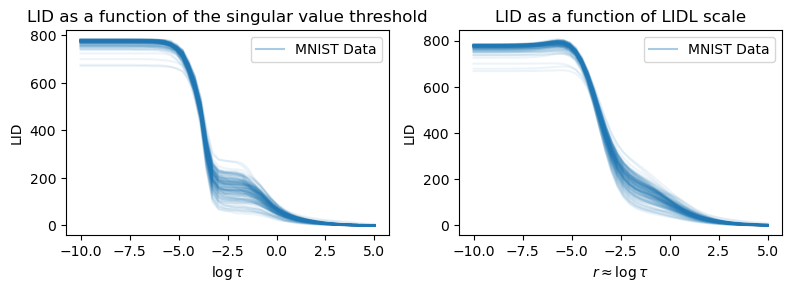

In [21]:
#| label: fig-lid-curve-flow
#| fig-cap: "Visualizing the LID curve of flow-based estimators, the left plot shows the LID curve of the Jacobian threshold estimator on the MNIST dataset, while the right plot shows the LID curve of the fast LIDL estimator. Both plateau at a certain range of the sweeping argument."
#| warning: false
%autoreload 2
import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import re
from visualization.pretty import ColorTheme
from visualization.trend import plot_trends
# load the environment variables
dotenv.load_dotenv(override=True)
import os

def visualize_lid_curve(
    ax, 
    artifact_dir: str, 
    title: str, 
    method_name: str,
    label: str,
    alpha=0.01, 
    x_label="Sweeping argument", 
    y_label="LID"
):
    # find the directory {artifact_dir}/likelihood_generated/metrics=xxx.csv`
    lid_curve_dir = os.path.join(artifact_dir, method_name, "trends")
    trend_files = [f for f in os.listdir(lid_curve_dir) if re.match(r'trend_epoch=\d+\.csv', f)][-1]
    trend_in = pd.read_csv(os.path.join(lid_curve_dir, trend_files), index_col=0).values

    sweeping_args_file = [f for f in os.listdir(lid_curve_dir) if f.startswith("sweeping_range")][-1]
    sweeping_args_df = pd.read_csv(os.path.join(lid_curve_dir, sweeping_args_file), index_col=0)
    
    sweeping_arg = sweeping_args_df.columns[0]
    sweeping_values = sweeping_args_df[sweeping_arg].values

    for i in range(trend_in.shape[0]):
        ax.plot(sweeping_values, trend_in[i], color=ColorTheme.BLUE_FIRST.value, alpha=alpha)
    ax.plot([], [], color=ColorTheme.BLUE_SECOND.value, label=label)
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


fig, axs = plt.subplots(1, 2, figsize=(8, 3))

visualize_lid_curve(
    ax=axs[0],
    artifact_dir=os.getenv("LID_FLOW_JACOBIAN_THRESHOLD_MNIST"),
    title="LID as a function of the singular value threshold",
    method_name="JacobianThresholdEstimatorCurve",
    alpha=0.08,
    x_label="$\\log \\tau$",
    label="MNIST Data",
)
visualize_lid_curve(
    ax=axs[1],
    artifact_dir=os.getenv("LID_FLOW_FAST_LIDL_MNIST"),
    method_name="FastFlowLIDLCurve",
    title="LID as a function of LIDL scale",
    alpha=0.08,
    x_label="$\\delta \\approx \\log \\tau$",
    label="MNIST Data",
)
plt.tight_layout(pad=1.0)
plt.show()





#### The Jacobian Threshold Estimator

This estimator simply computes the singular values of the Jacobian and uses a threshold for which all the singular values above that correspond to on-manifold directions. This estimator can also entail an LID curve: showing for each individual datapoint, the LID estimate as a function of the threshold, this will give a more holistic view of the manifold locally around each datapoint. To run this LID curve, for example on the MNIST dataset, run the following command:

```{.bash}
# set a smaller subsample size to make the run faster
python scripts/train.py dataset=mnist +experiment=train_flow_greyscale +checkpoint=flow_mnist +callbacks@all_callbacks.monitor_lid=flow_jacobian_threshold_lid_curve all_callbacks.monitor_lid.subsample_size=128
dotenv set LID_FLOW_JACOBIAN_THRESHOLD_MNIST "<artifact-dir>"
```

Or the following for a lollipop dataset:

```{.bash}
# this might take some time because it will also train a model
python scripts/train.py dataset=lollipop +experiment=train_flow_tabular train.trainer.max_epochs=3   +callbacks@all_callbacks.monitor_lid=flow_jacobian_threshold_lid_curve
dotenv set LID_FLOW_JACOBIAN_THRESHOLD_LOLLIPOP <artifact-dir>
```

The following piece of code will visualize the LID curve as well as the estimates for a calibrated value of threshold $\tau$ on the Lollipop dataset.



/tmp/ipykernel_4154678/3507012461.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


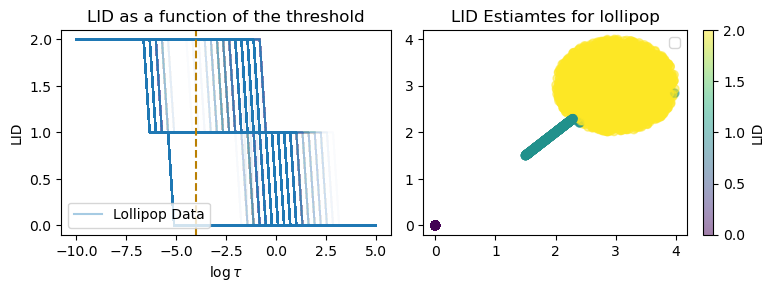

In [33]:
#| label: fig-lid-curve-flow-lollipop
#| fig-cap: "Visualzing the LID curve and estimates of the flow-based method for the lollipop dataset. The left plot shows the LID curve of the Jacobian threshold estimator, where you can see different clusters of data. At a given threshold $\\tau=-4$ it seems that a cluster of points estimate LID=2, a cluster LID=1, and a cluster LID=0. The right plot shows the LID estimates of these points on a scatterplot, indeed, showing that the ones on the stick are estimated as 1, the ones on the candy as 2, and the ones on the isolated point are estimated as 0."
#| warning: false
# load the environment variables
import dotenv
import numpy as np
dotenv.load_dotenv(override=True)
from visualization.pretty import ColorTheme

def visualize_scatterplot(
    ax, 
    artifact_dir: str, 
    title: str, 
    method_name: str,
    label: str,
    alpha=0.01, 
):
    # find the directory {artifact_dir}/likelihood_generated/metrics=xxx.csv`
    lid_curve_dir = os.path.join(artifact_dir, method_name, "trends")
    trend_files = [f for f in os.listdir(lid_curve_dir) if re.match(r'trend_epoch=\d+\.csv', f)][-1]
    trend_in = pd.read_csv(os.path.join(lid_curve_dir, trend_files), index_col=0).values

    sweeping_args_file = [f for f in os.listdir(lid_curve_dir) if f.startswith("sweeping_range")][-1]
    sweeping_args_df = pd.read_csv(os.path.join(lid_curve_dir, sweeping_args_file), index_col=0)
    
    sweeping_arg = sweeping_args_df.columns[0]
    sweeping_values = sweeping_args_df[sweeping_arg].values

    # find the index that has sweeping_values close to -4
    idx = np.abs(sweeping_values + 4).argmin()
    
    points = pd.read_csv(os.path.join(artifact_dir, method_name, "samples", "datapoints.csv"), index_col=0).values

    lid_values = trend_in[:, idx]

    # createa a scatterplot of points with each point being colored by the LID value
    ax.scatter(points[:, 0], points[:, 1], c=lid_values, cmap="viridis", alpha=0.5)
    # also show the colorbar
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label("LID")
    ax.set_title(title)
    ax.legend()


fig, axs = plt.subplots(1, 2, figsize=(8, 3))

visualize_lid_curve(
    ax=axs[0],
    artifact_dir=os.getenv("LID_FLOW_JACOBIAN_THRESHOLD_LOLLIPOP"),
    title="LID as a function of the threshold",
    method_name="JacobianThresholdEstimatorCurve",
    alpha=0.01,
    label="Lollipop Data",
    x_label="$\\log \\tau$",
)
axs[0].axvline(x=-4, color=ColorTheme.PIRATE_GOLD.value, linestyle="--")
visualize_scatterplot(
    ax=axs[1],
    artifact_dir=os.getenv("LID_FLOW_JACOBIAN_THRESHOLD_LOLLIPOP"),
    method_name="JacobianThresholdEstimatorCurve",
    title="LID Estiamtes for lollipop",
    alpha=0.08,
    label="Lollipop Data",
)
plt.tight_layout(pad=1.0)
plt.show()


#### Fast Flow LIDL (Advanced)

This is a continuous proxy for the Jacobian threshold approach. It is based on [Tempczyk et al.](https://arxiv.org/abs/2206.14882) (LIDL) and [Kamkari et al.](https://openreview.net/pdf?id=jQ596tXT3k), which is a previous version of [@kamkari2024oodlid] and the LID is approximated by a continuous proxy of the Jacobian thresholding. While the thresholding approach is much simpler and promising, the fact that this estimator also produces similar results and is both continuous and differentiable makes it worthwhile mentioning here.

The basic theory stems from LIDL, where LID can be approximated by how fast the log probability of a datapoint washes out as we add more and more Gaussian noise. We refer the reader to the paper for more details, but will state the main results here formally, defining the convolution between a pre-trained density $p_\theta$ and a Gaussian with log standard deviation $r$ as 
\begin{align}
\begin{aligned}
    \varrho_\delta(\mathbf{x})& := [p_\theta(\cdot )* \mathcal{N}(\ \cdot \ ; \mathbf{0}, e^{2\delta}\mathbf{I}_d)](\mathbf{x}) \\
    &=\int p_\theta(\mathbf{x}{-}\mathbf{x}')\mathcal{N}(\mathbf{x}'; \mathbf{0}, e^{2\delta}\mathbf{I}_d) \mathbf{d} \mathbf{x}',
\end{aligned}
\end{align}
[@tempczyk2022lidl] showed that under mild regularity conditions, for sufficiently negative $\delta$ (i.e.\ small standard deviation),
\begin{equation}
     \log \varrho_{\delta}(\mathbf{x}) = \delta (\text{LID}_\theta(\mathbf{x}) - d) + \mathcal{O}(1).
\end{equation}

\autoref{eq:LIDL-results} implies that, for sufficiently negative $r$ (corresponding to sufficiently small noise), the rate of change of $\log \varrho_\delta(\mathbf{x}_0)$ with respect to $r$ can be used to estimate LID, since $\frac{\partial}{\partial r} \log \varrho_\delta(\mathbf{x}_0) \approx \text{LID}_\theta(\mathbf{x}_0) - d$. 


In LIDL, estimating $\varrho_\delta(\mathbf{x}_0)$ requires training a separate density model for each $r$ value of interest. This is computationally expensive. Instead, we propose a way to leverage the properties of NFs to approximate $\varrho_\delta(\mathbf{x}_0)$. We assume that our normalizing flow has trained a push-forward $f_\theta: \mathcal{Z} \to \mathcal{X}$ from a latent space $\mathcal{Z}$ to the data space $\mathcal{X}$.
Given a reference point $\mathbf{x}_0$ and using a first order Taylor approximation of $f_\theta$ around $\mathbf{z}_0 = f^{-1}_\theta (\mathbf{x}_0)$, we approximate the NF as an affine function $f_\theta(\mathbf{z}) \approx \mathbf{J}_0 (\mathbf{z} - \mathbf{z}_0) + \mathbf{x}_0$, where $\mathbf{J}_0$ is the Jacobian of $f_\theta$ evaluated at $\mathbf{z}_0$ and is tractable by design. Since $p_\mathcal{Z}$ is Gaussian and affine transformations of Gaussians remain Gaussian, we can thus approximate $p_\theta(\mathbf{x})$ as $\hat{p}_\theta(\mathbf{x}) \coloneqq \mathcal{N}(\mathbf{x}; \mathbf{x}_0 - \mathbf{J}_0 \mathbf{z}_0, \mathbf{J}_0 \mathbf{J}_0^\top)$. While it might at first appear strange to approximate a function $f_\theta$ and a density $p_\theta$ that we can already evaluate, this approximation makes convolutions analytically tractable. By convolving $\hat{p}_\theta$ (instead of $p_\theta$) with a Gaussian, we can approximate $\varrho_\delta(\mathbf{x}_0)$ from \autoref{eq:rho_def} as

\begin{align}
    \begin{aligned}
        \hat{\varrho}_\delta(\mathbf{x}_0) &\coloneqq \int \hat{p}_\theta(\mathbf{x}_0 - \mathbf{x}) \mathcal{N}(\mathbf{x}; \mathbf{0}, e^{2\delta}\mathbf{I}_d)\mathbf{d} \mathbf{x} \\
        &= \mathcal{N}(\mathbf{x}_0; \mathbf{x}_0 - \mathbf{J}_0 \mathbf{z}_0, \mathbf{J}_0 \mathbf{J}_0^\top + e^{2\delta}\mathbf{I}_d).
    \end{aligned}
\end{align}

For a detailed analysis of the quality of this approximation, we refer the reader to the [paper](https://openreview.net/pdf?id=jQ596tXT3k). However, we can now simply compute the derivative of the log-density computed above to obtain an estimator for LID. Note that to have a shared nomanclature with the other components, we will use $\tau := e^\delta$ and $\log \tau \approx \delta$ whenever we refer to these estimators. There's an interpretation of $e^\delta$ acting as a threshold over the singular values of the Jacobian of the flow push-forward, and the estimator is essentially a *continuous and differentiable proxy* for the Jacobian threshold estimator.


To run this estimator, for example on the MNIST dataset, run the following command:

```{.bash}
python scripts/train.py dataset=mnist +experiment=train_flow_greyscale +checkpoint=flow_mnist +callbacks@all_callbacks.monitor_lid=fast_flow_lidl_curve all_callbacks.monitor_lid.subsample_size=128
dotenv set LID_FLOW_FAST_LIDL_MNIST <artifact-dir>
```

### Diffusion Estimators: Using the Score Function

#### Normal Bundle Estimator

This estimator is based on a study by [@stanczuk2022your] where the score function is sampled around the manifold and the LID is estimated based on the normal bundles of the manifold. To run this estimator, for example on the MNIST dataset, run the following command:

```bash
# you can change the frequency to control how often during training you want to monitor LID
python scripts/train.py dataset=mnist +experiment=train_diffusion_greyscale +checkpoint=diffusion_mnist +callbacks@all_callbacks.monitor_lid=normal_bundle_lid_curve all_callbacks.monitor_lid.subsample_size=128
dotenv set LID_DIFFUSION_NORMAL_BUNDLE_MNIST <artifact-dir>
```

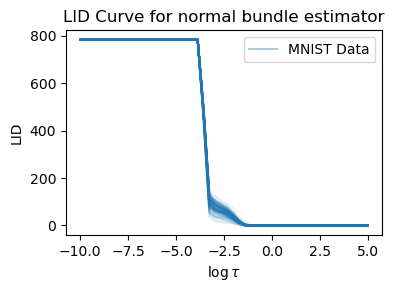

In [15]:
import dotenv
dotenv.load_dotenv(override=True)
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

visualize_lid_curve(
    ax=axs,
    artifact_dir=os.getenv("LID_DIFFUSION_NORMAL_BUNDLE_MNIST"),
    title="LID Curve for normal bundle estimator",
    method_name="NormalBundleEstimatorCurve",
    alpha=0.08,
    x_label="$\\log \\tau$",
)
plt.tight_layout(pad=1.0)
plt.show()

This will also log an LID curve where for each datapoint the LID is evaluated as a function of a threshold $\tau$. For more information check out the appropriate section in []() that subsantiates how to adapt this method for vairane-preserving diffusion models.

### Fokker Planck Estimator (FLIPD: Coming soon!)

When posted, you can run our estimator [FLIPD](https://arxiv.org/abs/2406.03537) [@kamkari2024flipd] here!


### LIDL Estimator

This is a method proposed by [@tempczyk2022lidl]. Unlike the other estimators, this one trains an ensemble of density estimation models (typically normalizing flows, but can also be diffusions). Therefore, the LID monitoring for this estimator is a bit different. To run this estimator, for example on the lollipop dataset, run the following command to train an ensemble of 8 models:

```{.bash}
python scripts/train.py dataset=lollipop +experiment=train_lidl_tabular dataset.train.size=4096 dataset.val.size=128 +callbacks@all_callbacks.umap=umap all_callbacks.umap.frequency=1
```
**Note**: Here, the umap callback will actually generate multiple umap embeddings for each of the models in the ensemble.

Additional outputs include:

1. **log likelihood of perturbed data**: Every once in a while, the callback will compute the log_prob of all the datapoints for the different models in the ensemble. This is logged in the `lid_logs_{estimator_name}/trends/likelihood_trend_epoch={epoch}.png` and `lid_logs_{estimator_name}/trends/likelihood_trend_epoch={epoch}.csv` file where the x-axis are the different noise scales (the logarithm of the standard deviation of the Gaussian) and each trend represents a datapoint with the `y-value` being the log_prob of the datapoint for the model associated with a specific noise scale.
2. **Regression**: The result of doing a regression on the log_prob of the datapoints is logged in the `lid_logs_{estimator_name}/predictions/estimates_{epoch}.csv`. As always, the row numbers are consistent with the ones in the `manifold_info.csv` file. Thus, you can use that to evaluate the performance of LIDL.




### Stacking the LID Estimator Callbacks

As memtioned before, the LID estimators are implemented as callbacks in PyTorch Lightning. This means that you can stack them together and run them simultaneously to get the best comparison. The following is an example of stacking the Jacobian thresholding and Fast Flow LIDL estimator on lollipop:

```{.bash}
python scripts/train.py dataset=lollipop +experiment=train_flow_tabular train.trainer.max_epochs=30 +callbacks@all_callbacks.monitor_lid1=flow_jacobian_threshold_lid_curve all_callbacks.monitor_lid1.subsample_size=128 +callbacks@all_callbacks.monitor_lid2=fast_flow_lidl_curve all_callbacks.monitor_lid2.subsample_size=128
```
Obviously, we cannot stack LID estimators that use a different underlying model. For example, you cannot stack the Jacobian threshold estimator with the normal bundle estimator or any of the estimtors with the LIDL estimator.

## Model-based Estimators (using python SDK)

Apart from using scripts, you may also use our LID estimators in your own code. Everything related to LID is stored in `lid/` directory. The LID estimators all inherit the `LIDEstimator` class that has an `estiamte_lid` function that takes in a batch of datapoints and returns their LID estimates. Here, we include a simple example of using the closed-form diffusion (CFDM) estimator and the fast flow LIDL estimator on the Lollipop dataset.


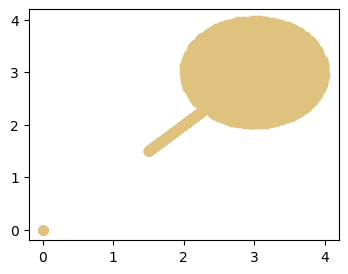

In [16]:
#| warning: false
#| label: fig-lollipop
#| fig-cap: "The lollipop dataset loaded."
import matplotlib.pyplot as plt
from visualization.pretty import ColorTheme
from data.datasets.generated import LIDSyntheticDataset
from data.distributions import Lollipop
%autoreload 2

dset = LIDSyntheticDataset(
    size=10000,
    distribution=Lollipop(),
    seed=42,
)
plt.figure(figsize=(4, 3))
plt.scatter(*dset.x.T, color=ColorTheme.GOLD.value)
plt.show()

### A model-free estimator

computing scatterplots: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


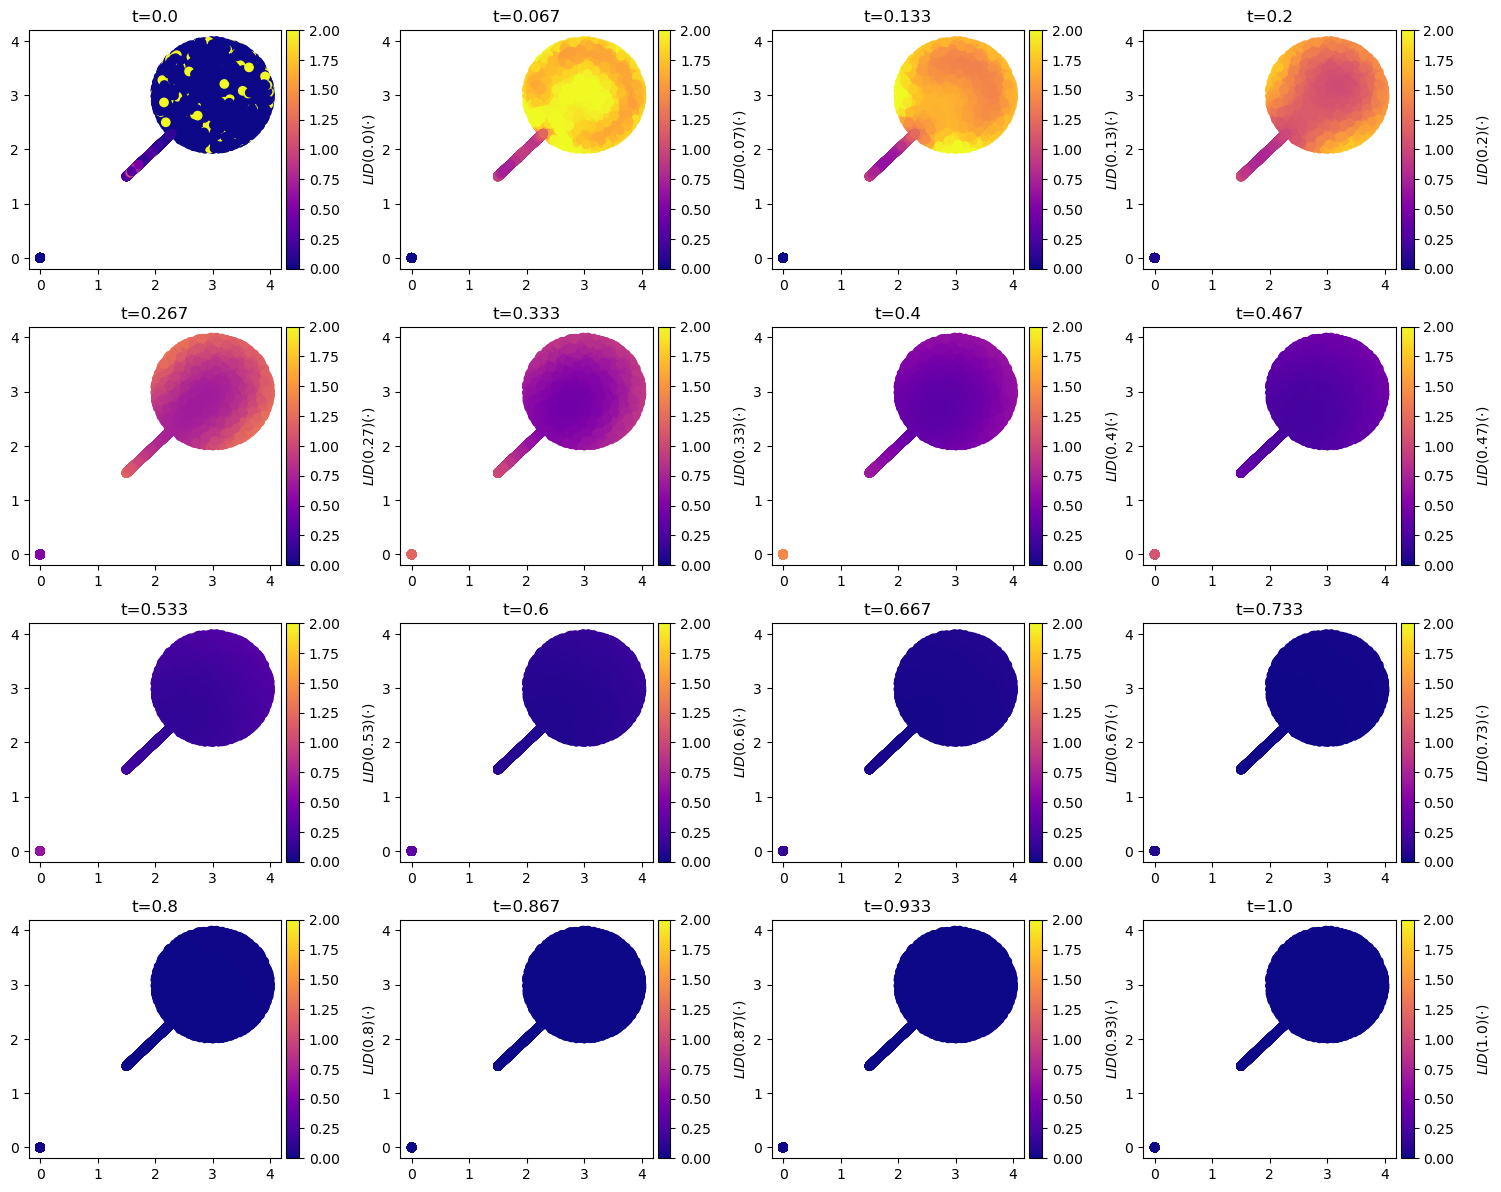

In [14]:
#| warning: false
#| fig-cap: "The LID estimates of the lollipop dataset using the closed form diffusion estimator. The LID estimator has a hyperparameter $t$ that controls the scale of the diffusion. The LID estimates are shown for different values of $t$ and a certain value of $t=0.067$ seems to be able to separate the lollipop from the stick."
%autoreload 2
from lid.diffusions import CFDM_LID
import numpy as np
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable


# instantiate the lid_estimator
lid_estimator = CFDM_LID(
    data=dset.x,
    ambient_dim=2,
    device=device,
    beta_min= 0.1,
    beta_max=20,
    t_max=1.0,
)
data=dset.x
t_values=np.linspace(1e-6, 1, 16)

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
# fig, axes = plt.subplots(1, 2, figsize=(16, 16))
assert len(t_values) == len(axes.flatten())
for ax, t in tqdm(
    zip(axes.flatten(), t_values),
    desc="computing scatterplots",
    total=len(t_values),
):  # Generate 1k points and plot them

    all_lid = lid_estimator.estimate_lid(
        data, t=t,
    ).cpu()

    # clip LID values
    all_lid = np.clip(all_lid, 0, lid_estimator.ambient_dim)

    s = ax.scatter(*data.cpu().T, c=all_lid, cmap="plasma", vmin=0, vmax=2)

    ax.set_title(f"t={round(t, 3)}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(s, cax=cax, orientation="vertical")

    cbar.set_label(f"$LID({{{round(t, 2)}}})(\\cdot)$", rotation=90, labelpad=15)

fig.tight_layout(pad=1.0)
plt.show()
    

### A Model-based estimator

First, train a normalizing flow on the lollipop dataset:


/home/hamid/dgm-geometry/models/flows/diffeomorphisms/nflows.py:70: UserWarning: ActNorm is not recommended for use with coupling transforms, especially in data modelling!
  warnings.warn(
Training epochs [Batch 79/79]: 100%|██████████| 100/100 [00:11<00:00,  5.99s/it, loss=-0.824]


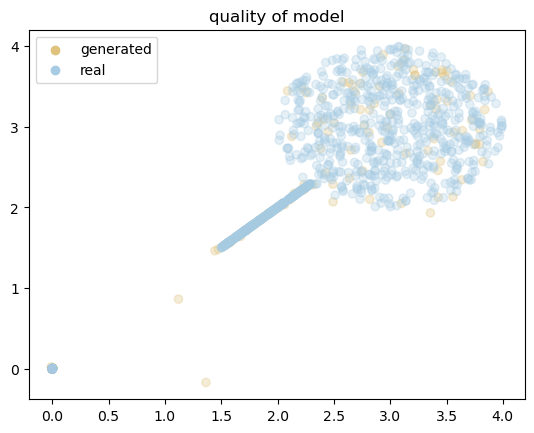

In [39]:
#| warning: false
#| fig-cap: "Training a flow model on lollipop and then generating the samples for evaluation. The samples are aligned with the original data, showing that the model has learned the distribution of the lollipop dataset."
from models.flows.training import LightningFlow
from models.training import LightweightTrainer
from functools import partial
from torch import optim
from nflows.flows.base import Flow
from nflows.distributions import StandardNormal
from models.flows.diffeomorphisms import RQNSF

flow_model = Flow(
  transform=RQNSF(
    dim=2,
    n_hidden=64, 
    n_blocks=2,
    tails="linear",
    num_bins=32,
    tail_bound=10.0,
    data_type="tabular",
    n_transforms=10,
    include_actnorm=True,
  ),
  distribution=StandardNormal(shape=[2]),  
)

training_module = LightningFlow(
    normalizing_flow=flow_model,
    optim_partial=partial(optim.Adam, lr=1e-4),
)
trainer = LightweightTrainer(
    max_epochs=100,
    device=device,
)
trainer.fit(
    model=training_module,
    train_dataloader=torch.utils.data.DataLoader(dset.x.to(device), batch_size=128),
    ckpt_path='outputs/notebooks/lollipop-flow/',
)
gen_samples = training_module.sample(128)
from visualization import visualize_umap_clusters
from visualization.pretty import ColorTheme

visualize_umap_clusters(
    data = [gen_samples.cpu().detach().numpy(), dset.x[:1000].cpu().numpy()],
    labels=["generated", "real"],
    title="quality of model",
    alpha=0.3,
    colors=[ColorTheme.GOLD.value, ColorTheme.BLUE_SECOND.value],
    return_img=False,
)

# The expected loss: < 0.71

Now let's estimate LID. Again, we have a hyperparametr for scale.

computing scatterplots: 100%|██████████| 16/16 [03:33<00:00, 13.32s/it, batch=[78/78]]


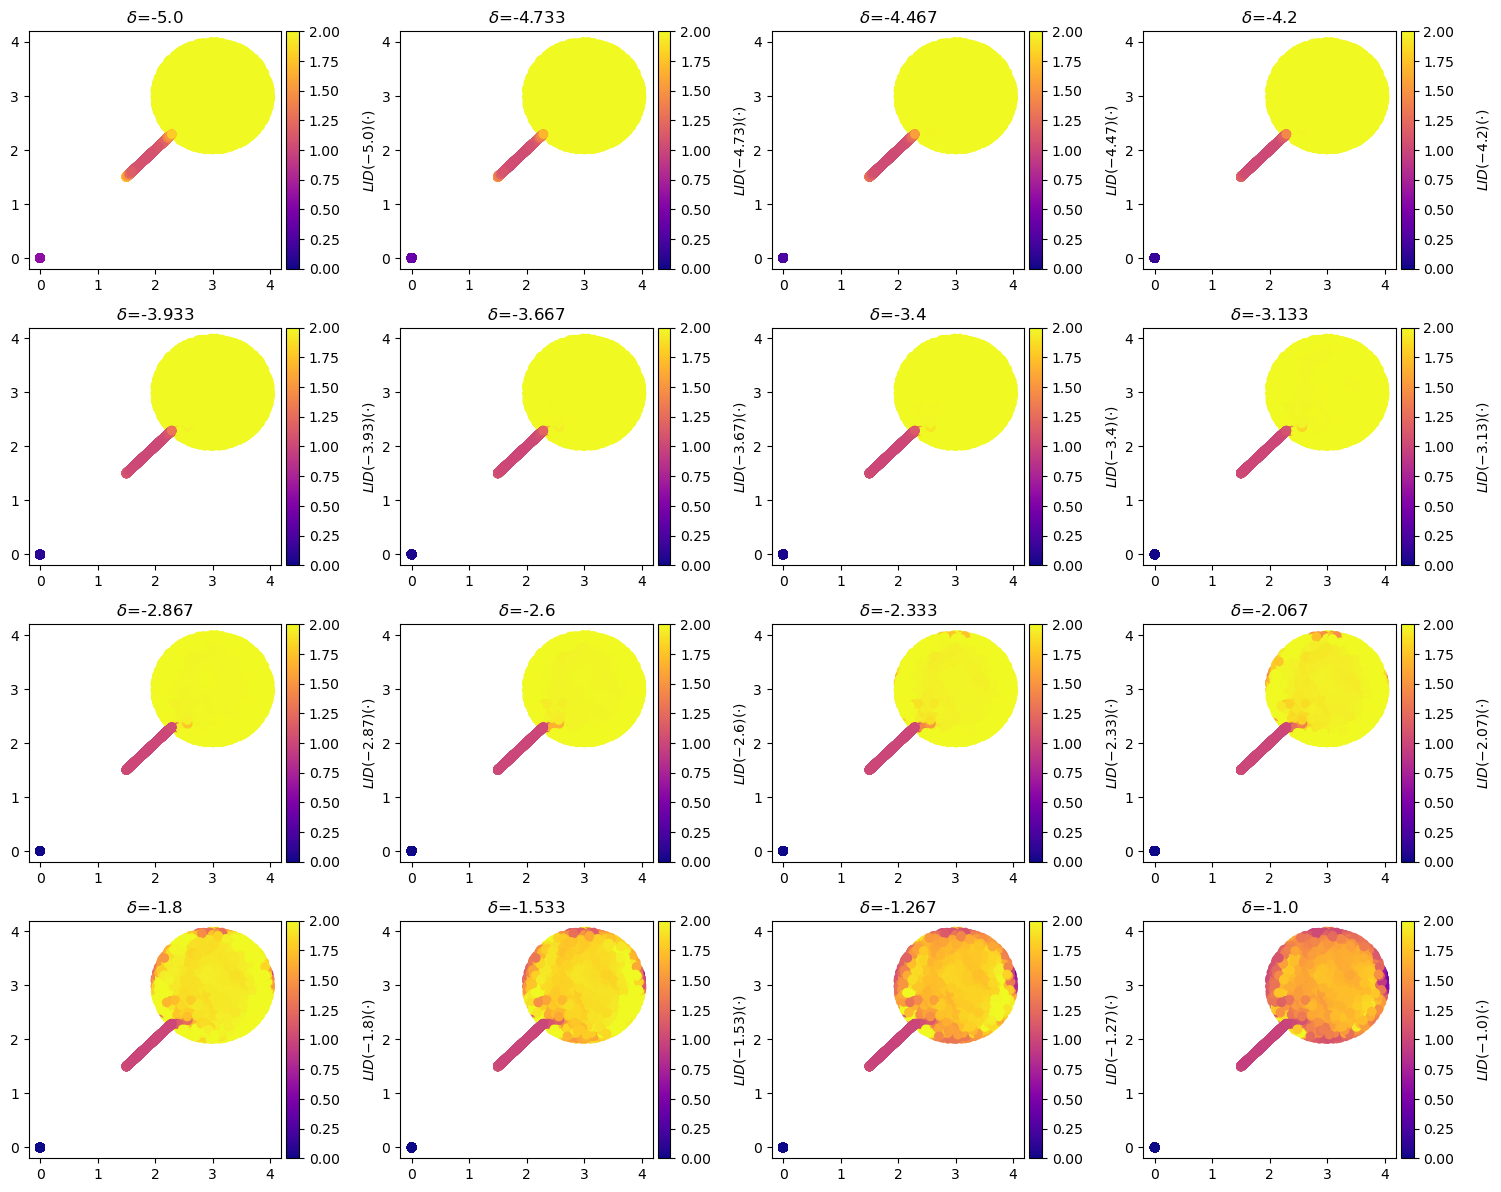

In [36]:


#| warning: false
#| fig-cap: "The LID estimates of the lollipop dataset using the fast LIDL estimator. The LID estimator has a hyperparameter $\delta$ that controls the scale of the estimator. The LID estimates are shown for different values of $\delta$ and a certain value of $\delta=-4.2$ seems to be able to separate the lollipop from the stick."
%autoreload 2
import numpy as np
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lid.flows import FastFlowLIDL

lid_estimator_flow = FastFlowLIDL(
    model=flow_model,
    device=device,
)

data=dset.x
delta_values=np.linspace(-5, -1, 16)

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
# fig, axes = plt.subplots(1, 2, figsize=(16, 16))
assert len(t_values) == len(axes.flatten())
iterator = tqdm(
    zip(axes.flatten(), delta_values),
    desc="computing scatterplots",
    total=len(delta_values),
)
for ax, delta in iterator:  # Generate 1k points and plot them

    all_lid = []
    for batch_idx, data_batch in enumerate(torch.split(data, 128)):
        all_lid.append(lid_estimator_flow.estimate_lid(data_batch, delta=delta).cpu())
        iterator.set_postfix({"batch": f"[{batch_idx}/{len(data)//128}]"})
    all_lid = torch.cat(all_lid)
    # clip LID values
    all_lid = np.clip(all_lid, 0, lid_estimator.ambient_dim)

    s = ax.scatter(*data.cpu().T, c=all_lid, cmap="plasma", vmin=0, vmax=2)

    ax.set_title(f"$\\delta$={round(delta, 3)}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(s, cax=cax, orientation="vertical")

    cbar.set_label(f"$LID({{{round(delta, 2)}}})(\\cdot)$", rotation=90, labelpad=15)

fig.tight_layout(pad=1.0)
plt.show()
    

<!-- 
## References -->
<!-- 
::: {#refs}
::: -->